In [1]:
import warnings
warnings.filterwarnings("ignore")

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import CoxTimeVaryingFitter

# Modèle de Cox à Effets Mixtes
## Import des données

In [2]:
df = pd.read_csv('../data/base_modelis_pass_det.csv',sep = ';')

In [3]:
df.shape

(329064, 90)

## Traitement des données
Contrairement aux autres modèles, nous appliquons une préparation des donneés spécifiques à ce modèle

In [4]:
liste_var = ['cd_op','fl_pass_DET','arrete','date_entree_defaut','cum_frs_externes','MT_CHG_MSL',
             'sol_echec','MT_EAD_RESID','MR_arr','dls_ges_def','mt_dec_cum_IMP_tot']

df = df[liste_var]

### Type et valeurs manquantes

In [5]:
df['date_entree_defaut'] = pd.to_datetime(df['date_entree_defaut'], format='%d/%m/%y')
df['arrete'] = pd.to_datetime(df['arrete'], format='%d/%m/%y')

In [6]:
for column in df.columns :
    if df[column].isna().sum()/df.shape[0] > 0.3 : 
        df.drop(columns = [column], inplace = True)

In [7]:
cols_numeriques = df.select_dtypes(exclude=['object']).columns.to_list()
cols_categorielles = df.select_dtypes(include=['object']).columns.to_list()
cols_categorielles.remove("cd_op")

In [8]:
for col in cols_numeriques:
    df[col].fillna(df[col].mean(), inplace=True)

for col in cols_categorielles:
    df[col].fillna(df[col].mode()[0], inplace=True)

### Encoding des catégorielles

In [9]:
precaire = ['0_1', '1_1']

df['Solution_echec'] = np.where(df['sol_echec'].isin(precaire), 'Mauvaise solution', 'Bonne solution')
df['Solution_echec'] = df['Solution_echec'].apply(lambda x : 2 if x == 'Mauvaise solution' else 1)
df.drop(columns ='sol_echec', inplace = True)

### Split des données : Entraînement / Test

In [10]:
df_validation = df[df['arrete']>"2020-12-30"]
df_train = df[df['arrete']<"2020-12-30"]
df_train = df_train.reset_index()

In [11]:
df_train_var = df.copy()
df_test_var = df_validation.copy()

### Selection des individus réellement censurés et des fl_pass_DET=1

In [12]:
df_train_var.index = df_train_var['cd_op'] 
df_test_var.index = df_test_var['cd_op']

In [13]:
# on récupère les données non censurées
liste_target_1 = df_train_var[df_train_var['fl_pass_DET']==1].index.to_list() 
liste_target_1_test = df_test_var[df_test_var['fl_pass_DET']==1].index.to_list()

In [14]:
# on recupère les id censurés
liste_target_censure = df_train_var[df_train_var['arrete']=='2022-12-31'].index.to_list() 
liste_target_censure_test = df_test_var[df_test_var['arrete']=='2022-12-31'].index.to_list()

In [15]:
# on combine les 2 listes
liste_target_censure.extend(liste_target_1) 
liste_target_censure_test.extend(liste_target_1_test)

In [16]:
# on supprime les doublons
liste_cd_op = set(liste_target_censure) 
liste_cd_op = list(liste_cd_op)

liste_cd_op_test = set(liste_target_censure_test)
liste_cd_op_test = list(liste_cd_op_test)

In [17]:
len(liste_cd_op) # On a donc 11301 individus à traiter dans notre base de données

11301

In [18]:
len(liste_cd_op_test)

6295

In [19]:
data_train = df_train_var[df_train_var['cd_op'].isin(liste_cd_op)]
data_test = df_test_var[df_test_var['cd_op'].isin(liste_cd_op_test)]

### Création des variables modélisant le temps passé pour le modèle

In [20]:
data_train['start'] = 0
data_train['stop'] = data_train['arrete'] - data_train['date_entree_defaut']
data_train['stop'] = data_train['stop'].dt.days

data_test['start'] = 0
data_test['stop'] = data_test['arrete'] - data_test['date_entree_defaut']
data_test['stop'] = data_test['stop'].dt.days

In [21]:
data_train['id'] = data_train['cd_op'].apply(lambda x: re.sub(r'\D', '', str(x)))
data_test['id'] = data_test['cd_op'].apply(lambda x: re.sub(r'\D', '', str(x)))

In [22]:
data_train.id = data_train.id.astype('int')

In [23]:
data_train.loc[(data_train['start'] == data_train['stop']) & (data_train['start'] == 0) & data_train[
    'fl_pass_DET'], 'stop'] = 0.5  # car le modele n'accepte pas les individus qui sortent de la survie au moment ou ils y entrent donc on remplace les 0 par 0.5.

data_test.loc[(data_test['start'] == data_test['stop']) & (data_test['start'] == 0) & data_test[
    'fl_pass_DET'], 'stop'] = 0.5 

In [24]:
data_haz = data_train.select_dtypes(exclude=["datetime64"])
data_test = data_test.select_dtypes(exclude=["datetime64"])

In [25]:
data_haz.drop(columns = ["cd_op"], inplace = True)
data_test.drop(columns = ["cd_op"], inplace = True)

# Modélisation

In [26]:
ctv = CoxTimeVaryingFitter(penalizer=0.2)
ctv.fit(data_haz, id_col="id", event_col="fl_pass_DET", stop_col="stop", show_progress=True)

Iteration 1: norm_delta = 3.89e-01, step_size = 0.9500, log_lik = -82428.72295, newton_decrement = 3.73e+03, seconds_since_start = 12.0
Iteration 2: norm_delta = 1.54e+00, step_size = 0.9500, log_lik = -115368.84064, newton_decrement = 2.77e+05, seconds_since_start = 23.7
Iteration 3: norm_delta = 1.60e+00, step_size = 0.9500, log_lik = -128047.15070, newton_decrement = 5.07e+04, seconds_since_start = 35.6
Iteration 4: norm_delta = 1.07e+01, step_size = 0.9310, log_lik = -164596.58934, newton_decrement = 2.67e+06, seconds_since_start = 47.6
Iteration 5: norm_delta = 2.46e+00, step_size = 0.2281, log_lik = -2149259.21837, newton_decrement = 2.07e+06, seconds_since_start = 59.5
Iteration 6: norm_delta = 2.43e+00, step_size = 0.2906, log_lik = -1312057.57832, newton_decrement = 1.24e+06, seconds_since_start = 71.4
Iteration 7: norm_delta = 2.91e+00, step_size = 0.4911, log_lik = -696861.17374, newton_decrement = 6.23e+05, seconds_since_start = 83.3
Iteration 8: norm_delta = 1.87e+00, step

<lifelines.CoxTimeVaryingFitter: fitted with 175878 periods, 11301 subjects, 7463 events>

In [27]:
ctv.print_summary()

<lifelines.CoxTimeVaryingFitter: fitted with 175878 periods, 11301 subjects, 7463 events>
         event col = 'fl_pass_DET'
         penalizer = 0.2
number of subjects = 11301
 number of periods = 175878
  number of events = 7463
partial log-likelihood = -79725.52
  time fit was run = 2024-02-10 16:11:07 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
cum_frs_externes    -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
MT_CHG_MSL          -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
MT_EAD_RESID        -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
MR_arr               0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
dls_ges_def         -0.01       0.99       0.00            -0.02            -0.01                 0.98                 0.99
mt_dec_cum_IMP_tot  -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Solution_echec       0.00       1.00       0.01            -0.02             0.03                 0.98                 1.03

                     cmp to      z      p   -log2(p)
covariate                                           
cum_frs_externes       0.00 -13.59 <0.005     137.34
MT_CHG_MSL             0.00  -6.80 <0.005      36.45
MT_EAD_RESID           0.00 -14.29 <0.005     151.46
MR_arr                 0.00  72.79 <0.005        inf
dls_ges_def            0.00 -36.51 <0.005     967.12
mt_dec_cum_IMP_tot     0.00  -1.21   0.23       2.14
Solution_echec         0.00   0.47   0.64       0.64
---
Partial AIC = 159465.04
log-likelihood ratio test = 5406.40 on 7 df
-log2(p) of ll-ratio test = inf

In [28]:
data_haz.columns

Index(['fl_pass_DET', 'cum_frs_externes', 'MT_CHG_MSL', 'MT_EAD_RESID',
       'MR_arr', 'dls_ges_def', 'mt_dec_cum_IMP_tot', 'Solution_echec',
       'start', 'stop', 'id'],
      dtype='object')

<Axes: xlabel='log(HR) (95% CI)'>

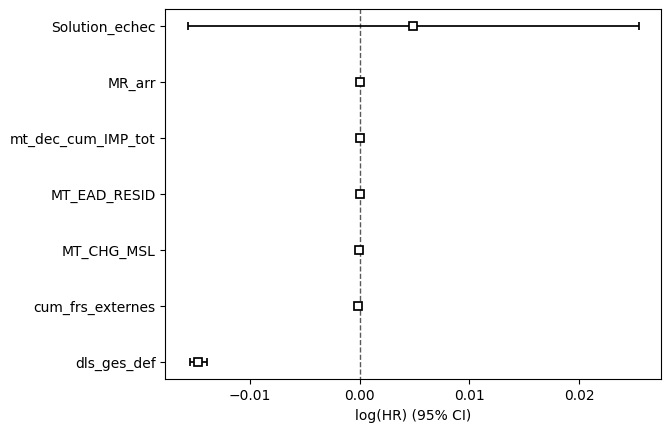

In [29]:
ctv.plot()

In [30]:
predictions = ctv.predict_partial_hazard(data_test)

In [31]:
predictions = pd.DataFrame(predictions)
predictions['id']= data_test['id'].index
predictions.rename(columns = {0:'pred'},inplace = True)